# Data Analysis

#### This notebook will be used for the analysis part of the project. Here we will explore and visualise the data to get a firm grasp on what the data looks like.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

## Import the datasets 

Two sets of data will be used in this project. 

1. The set of organisations fulfilled by the [IPEDS Data base](https://nces.ed.gov/ipeds/)
2. The customer behavior is a ficticious data set creating random numbers and ranges. Fingers crossed we have some correlation in the data. 


### Create sqlite dB engine and read the data to frames

In [2]:
#Configure sqlite db engine
engine = create_engine('sqlite:///../data/orgs_customer_behaviours.db')

# Read data to frame

# Import IPDES data
# The data comes in the form of csv
df_organisations_raw = pd.read_csv("../data/hd2019_convert.csv", encoding='latin1') #encoding had to be added to be able to read the file
# Import the synthetic customer behaviour data
df_synth_customer_behaviour_data = pd.read_sql_table('synth_customer_behaviour_data', engine)
df_synth_customer_target_classifier_data = pd.read_sql_table('synth_customer_target_classifier_data', engine)

df_combined_customer_data = df_synth_customer_behaviour_data.merge(df_synth_customer_target_classifier_data,
                             left_index=True, right_index= True)

In [3]:
# Define data shape 

raw_org_columns = df_organisations_raw.shape[1]
raw_org_rows = df_organisations_raw.shape[0]

# Manual identification of columns that will have values 
columns_of_value = ['UNITID', 'INSTNM', 'IALIAS', 'CITY', 'STABBR', 'FIPS', 'OBEREG','GENTELE', 'EIN', 'DUNS', 'OPEID', 
                    'OPEFLAG', 'SECTOR', 'ICLEVEL', 'CONTROL', 'HLOFFER', 'GROFFER', 'HDEGOFR1', 'DEGGRANT', 
                    'HBCU', 'HOSPITAL', 'MEDICAL', 'TRIBAL', 'LOCALE', 'ACT', 'DEATHYR', 'CYACTIVE', 
                    'POSTSEC', 'PSEFLAG', 'PSET4FLG', 'RPTMTH', 'INSTCAT', 'C18BASIC', 'C18IPUG', 'C18IPGRD', 'C18UGPRF', 
                    'C18ENPRF', 'C18SZSET', 'C15BASIC', 'CCBASIC', 'CARNEGIE', 'LANDGRNT', 'INSTSIZE', 'F1SYSTYP', 
                    'F1SYSCOD', 'COUNTYNM', 'CNGDSTCD', 'CONVERTED']

df_organisations = df_organisations_raw[columns_of_value]

In [4]:
# Filter the dataset to remove records that arent relevant
# Remove institutions that have closed down  or removed from IPEDS using column CLOSEDAT & DEATHYR

df_organisations_filtered = df_organisations.loc[(df_organisations['DEATHYR']==-2)]

## Uderstanding the data
* Get the shape of the data
* Identify columns with categorical values
* Visualise the organisations by state

In [5]:
raw_columns = df_organisations_raw.shape[1]
raw_rows = df_organisations_raw.shape[0]
org_columns = df_organisations.shape[1]
org_rows = df_organisations_raw.shape[0]
fil_org_columns = df_organisations_filtered.shape[1]
fil_org_rows = df_organisations_filtered.shape[0]
is_nulls_counts = len(df_organisations_filtered.columns[df_organisations_filtered.isnull().sum()==0])
categorical_vals = df_organisations_filtered.select_dtypes(include=['object'])
categorical_vals_columns = list(categorical_vals.columns)

print(f'The raw data has {raw_columns} columns and {raw_rows} rows')
print(f'The unfiltered reduced data has {org_columns} columns and {org_rows} rows')
print(f'The filtered organisations df has {fil_org_columns} columns and {fil_org_rows} rows')
print(f'The df has {df_organisations_filtered.shape[1]} columns without {is_nulls_counts} containing nulls')
print(f'There are {categorical_vals.shape[1]} columns with categorical values, they are in the columns: '
      f'\n\n{categorical_vals_columns}')


The raw data has 74 columns and 6559 rows
The unfiltered reduced data has 48 columns and 6559 rows
The filtered organisations df has 48 columns and 6388 rows
The df has 48 columns without 47 containing nulls
There are 8 columns with categorical values, they are in the columns: 

['INSTNM', 'IALIAS', 'CITY', 'STABBR', 'GENTELE', 'DUNS', 'ACT', 'COUNTYNM']


### The distribution of organisations across states
The Top 5 States with organisations: 
CA, NY, FL, PA, TX

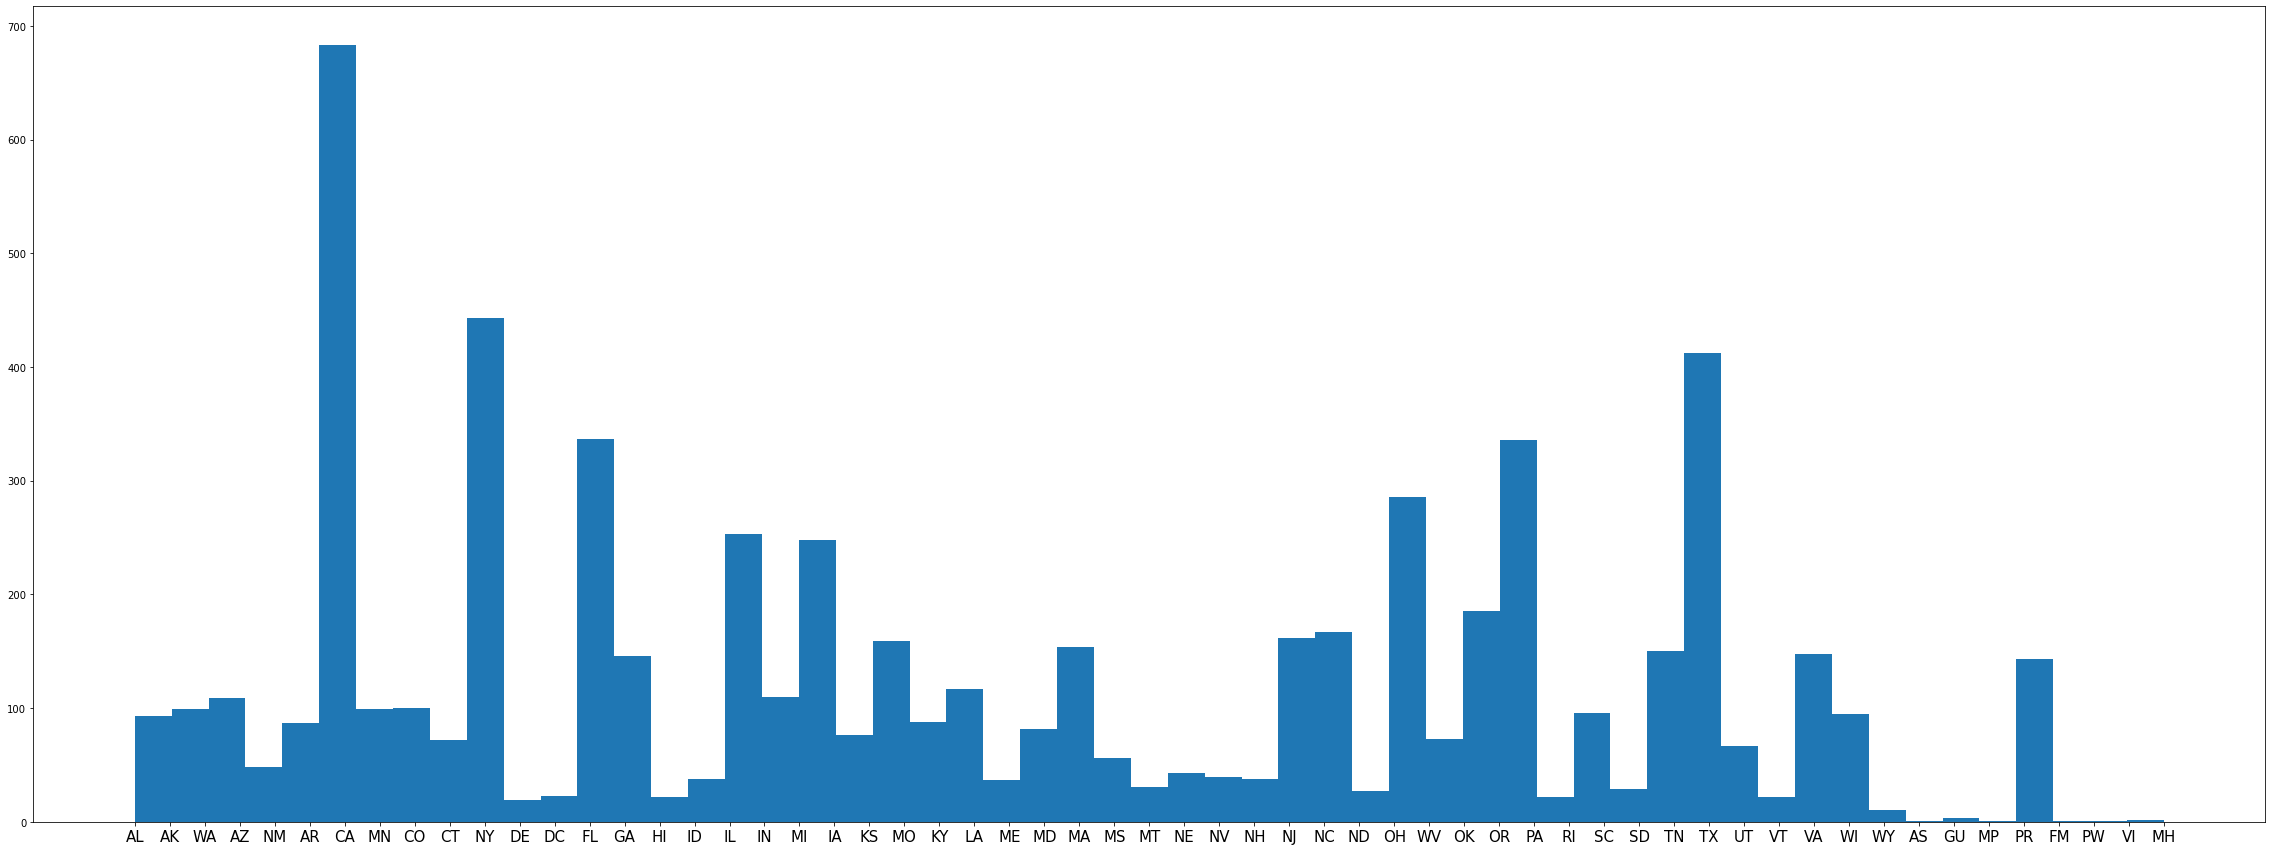

In [6]:
df_organisations_filtered['STABBR'].hist(bins=55, grid=False, figsize=(40, 15), xlabelsize=15);

In [7]:
cust_raw_columns = df_organisations_filtered.shape[1]
cust_raw_rows = df_organisations_filtered.shape[0]
cust_is_nulls_counts = len(df_organisations_filtered.columns[df_organisations_filtered.isnull().sum()==0])
cust_categorical_vals = df_organisations_filtered.select_dtypes(include=['object'])
cust_categorical_vals_columns = list(cust_categorical_vals.columns)

print(f'The raw customer data has {cust_raw_columns} columns and {cust_raw_rows} rows')
print(f'The customer df has {cust_is_nulls_counts} columns without null values')
print(f'There are {cust_categorical_vals.shape[1]} categorical values in the customer data set. They are in the columns: '
      f'\n\n{cust_categorical_vals_columns}')


The raw customer data has 48 columns and 6388 rows
The customer df has 47 columns without null values
There are 8 categorical values in the customer data set. They are in the columns: 

['INSTNM', 'IALIAS', 'CITY', 'STABBR', 'GENTELE', 'DUNS', 'ACT', 'COUNTYNM']


### Clean the datasets

#### Replace `-2` and `-1` values in the data set
The IPEDS database uses `-2` and `-1` to indicate `null` or empty values, this might cause issues when applying the segmentation logic. 

At this point I will replace all `[-2, -1]` values with `0`. The data set uses `[-2, -1]` in the context of `integer` and `string` values so both need to be accomodated 

In [8]:
df_organisations_data = df_organisations_filtered.replace([-2, '-2', -1, '-1'], 0)

### Save data to sql lite dB for further processing

In [9]:
df_organisations_data.to_sql('customers_with_behaviours', engine, if_exists='replace', index=False)
df_organisations_filtered.to_sql('orgs_organisations', engine, if_exists='replace', index=False)
# df.to_sql('correlation_data', engine, if_exists='replace', index=False)
# df.to_sql('dummies_data', engine, if_exists='replace', index=False)
# df.to_sql('dummies_with_ranges', engine, if_exists='replace', index=False)
df_combined_customer_data.to_sql('customer_behaviour_data', engine, if_exists='replace', index=False)

## Check correlations in dataset

I'll use the seaborn visualisations to illustrate the correlations 

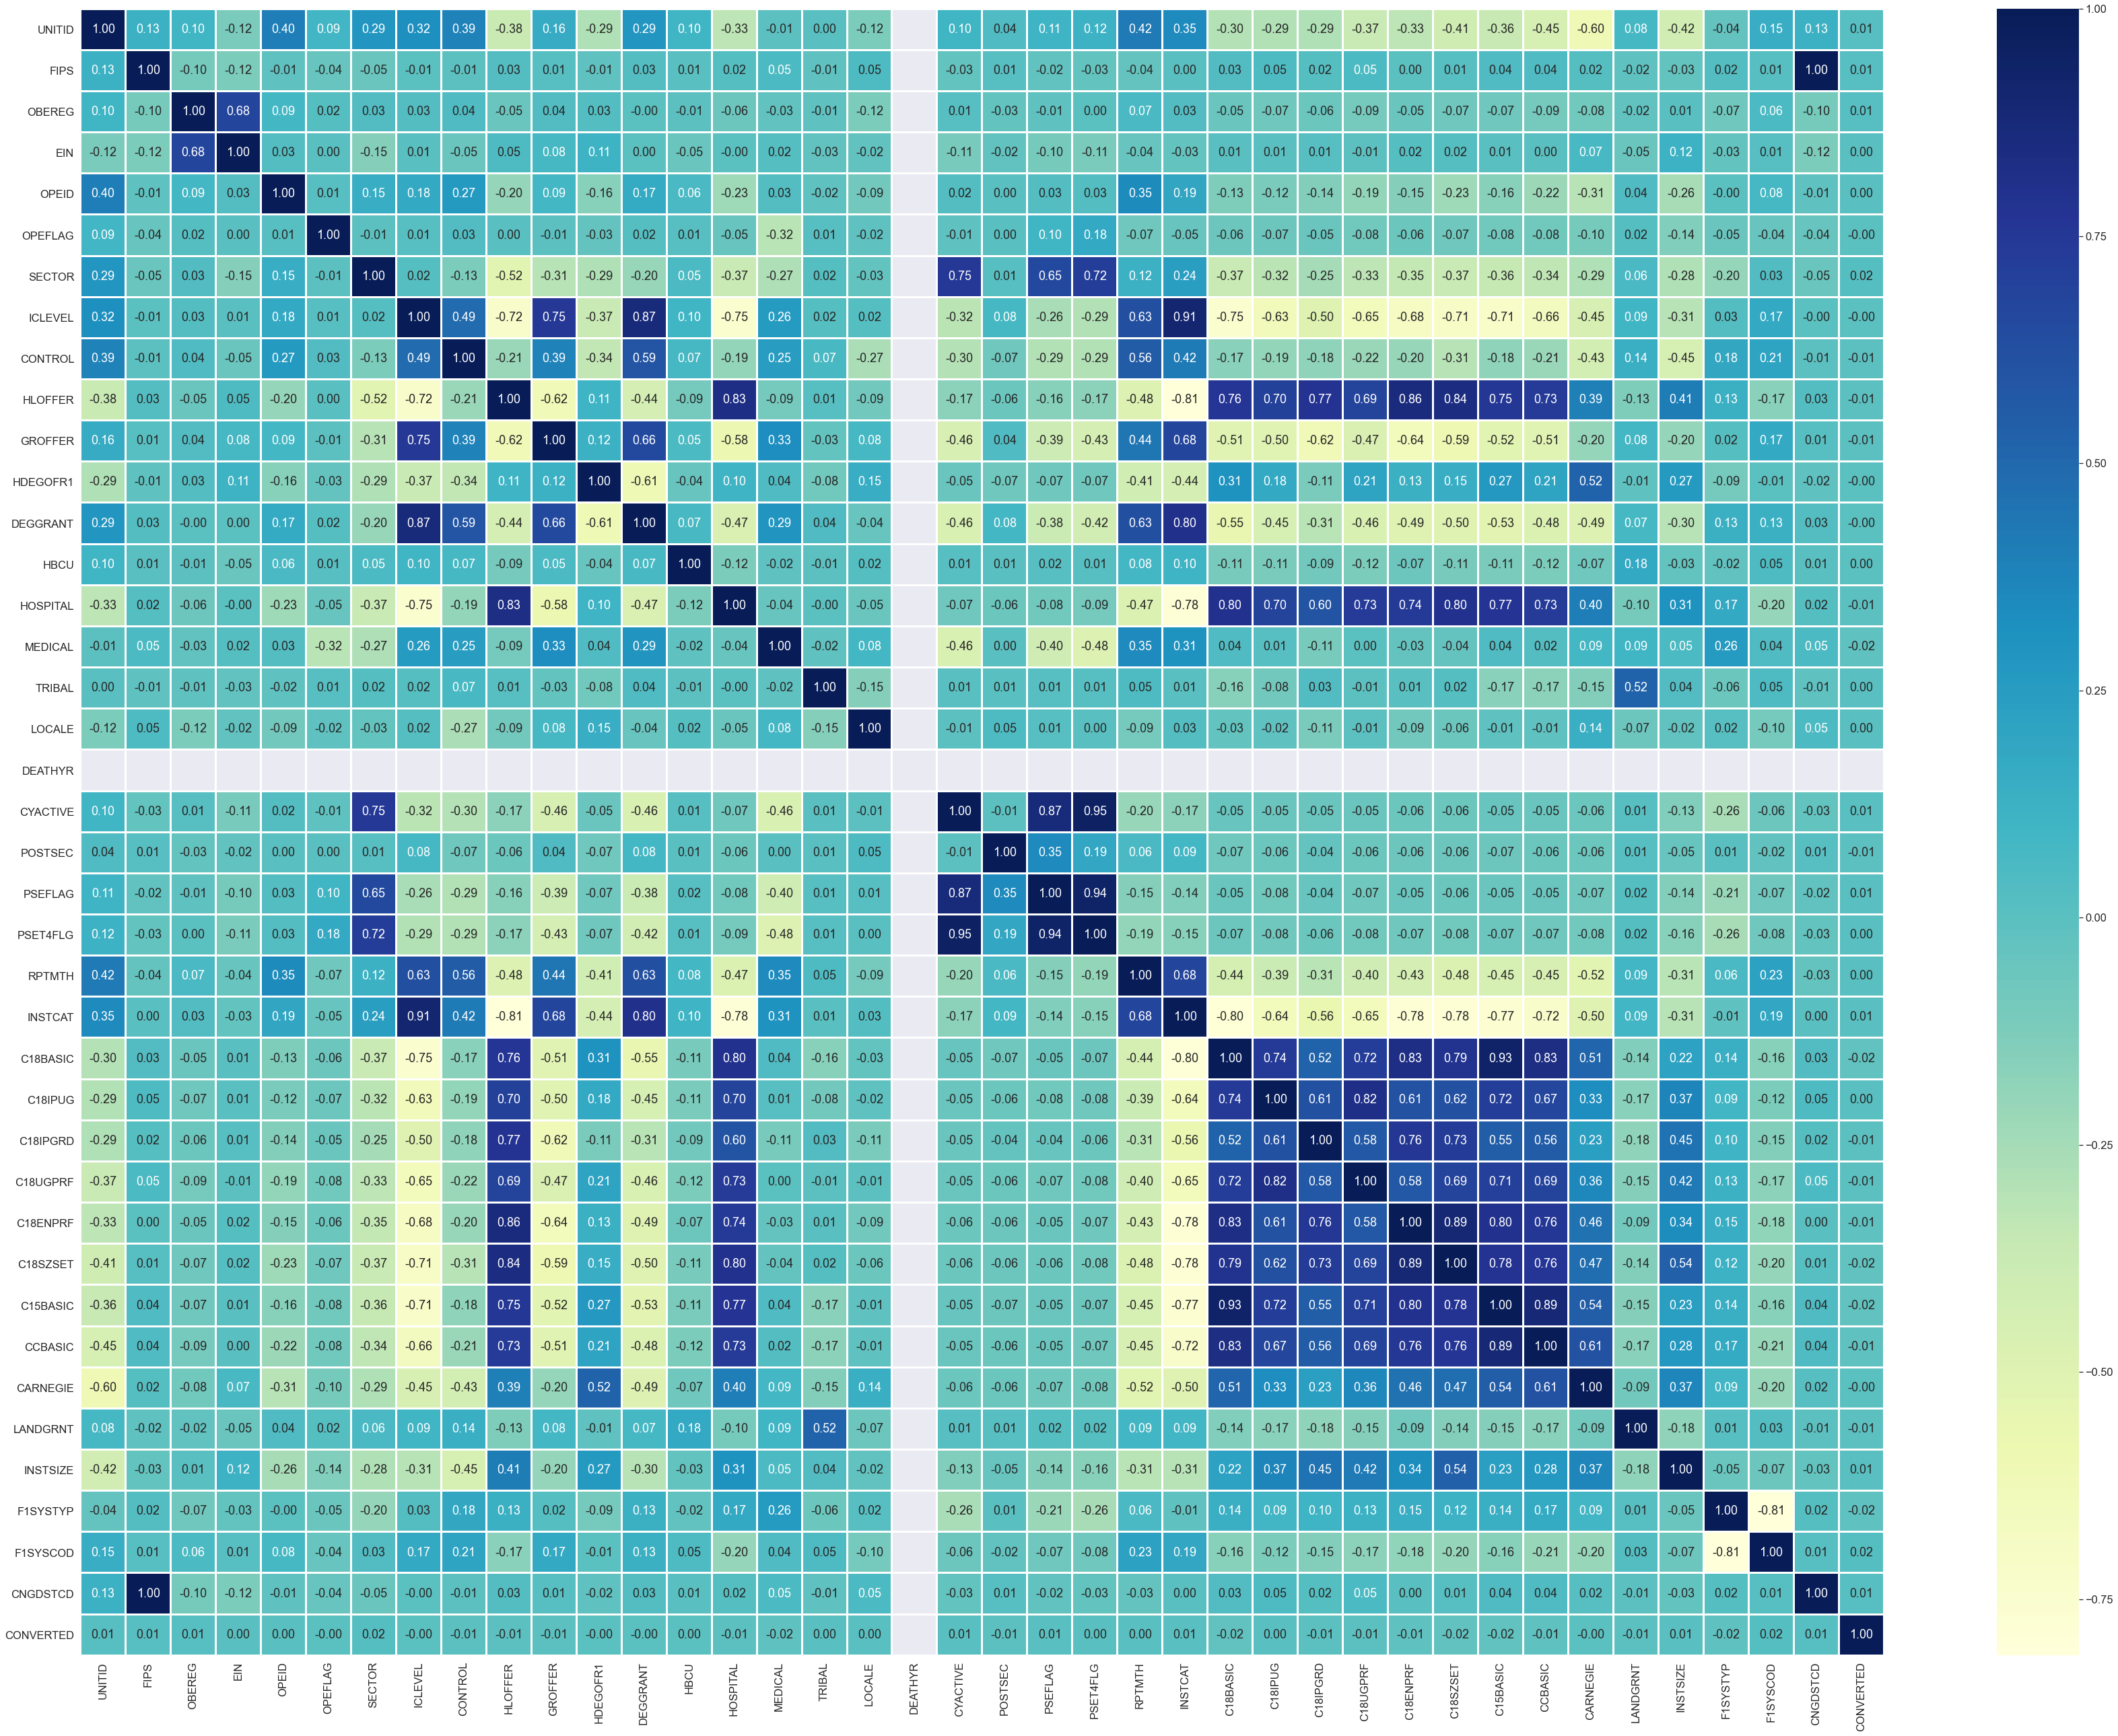

In [10]:
sns.set(font_scale=1.5)
plt.subplots(figsize=(60,45))
sns.heatmap(df_organisations_data.corr(), annot=True, linewidths=2, cmap="YlGnBu", fmt=".2f");

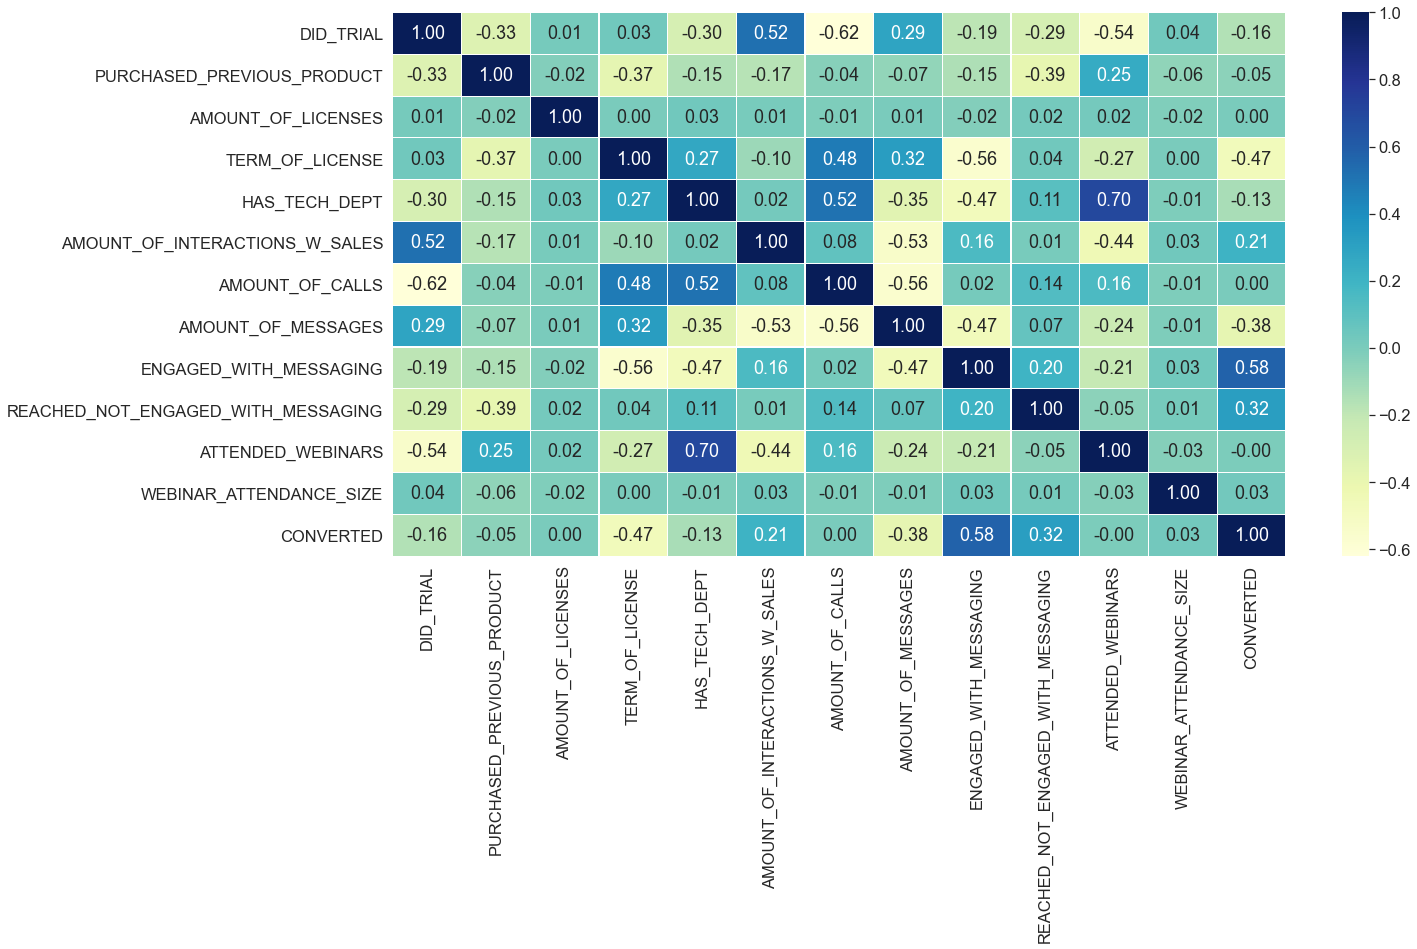

In [11]:
sns.set(font_scale=1.5)
plt.subplots(figsize=(20,10))
sns.heatmap(df_combined_customer_data.corr(), annot=True, linewidths=.1, cmap="YlGnBu", fmt=".2f");